In [3]:
%pylab inline
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import leastsq
def yvals(x):
    return np.sin(x)+np.sin(2*x)+np.sin(3*x)

dx = .01
X = np.arange(0,2*np.pi,dx)
Y = yvals(X)

unknown_shift = np.random.random() * dx
Y_shifted = yvals(X + unknown_shift)

def err_func(p):
    return interp1d(X,Y)(X[1:-1]+p[0]) - Y_shifted[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]
print(X.shape)

Populating the interactive namespace from numpy and matplotlib
(629,)


In [4]:
found_shift = leastsq(err_func,p0)[0][0]

print(f"Unknown shift:{unknown_shift} ")
print(f"Found shift:{found_shift} ")


Unknown shift:0.0025449216361505536 
Found shift:0.002544865092642783 


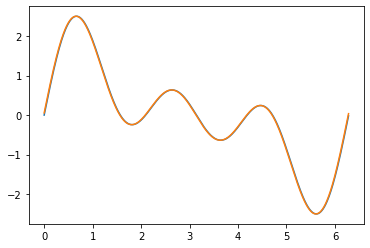

In [21]:
plt.plot(X,Y)
plt.plot(X,Y_shifted)

In [22]:
interp1d(f_time,f_vals)(f_time[1:-1])

NameError: name 'f_time' is not defined

In [34]:
def lag_calc(yy,yy_shifted):
    from scipy import signal

    xcorr = signal.correlate(yy,yy_shifted,mode='full')
    lags = signal.correlation_lags(yy.size,yy_shifted.size,mode='full')
    lag = lags[np.argmax(xcorr)]
    return lag

91


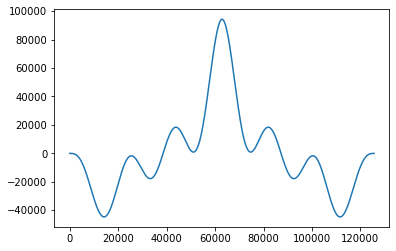

In [36]:
plt.plot(xcorr)

In [33]:

yy


array([ 0.        ,  0.00059994,  0.00119988, ..., -0.02091124,
       -0.02031138, -0.01971151])

In [5]:
import yaml
def load_yaml(fname):
    with open(fname, 'r') as file:
        data = yaml.safe_load(file)
    return data

def compute_normalized_force_response(device_force_values, MVC, forceRangeMin=0.05, forceRangeMax=0.30, clamp=None):
    """
    Convert from sensor values to heigt values that were used in the display for direct comparison to the target sequence. Works fine for any array.
    ((deviceForceValue / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)

    MVC:            maximumum voluntary contraction of this individual (in original device units)
    clamp:          list of min/max values to clamp any values that are above or below to, default = None (no clamping)
    """

    norm_resp = ((device_force_values / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)
    if clamp is not None:
        norm_resp[norm_resp<clamp[0]] = clamp[0]
        norm_resp[norm_resp>clamp[1]] = clamp[1]
    return norm_resp

In [82]:
def lag_calc(yy,yy_shifted):
    #easy way, with max res of 1 unit of time
    from scipy import signal

    xcorr = signal.correlate(yy,yy_shifted,mode='full')
    lags = signal.correlation_lags(yy.size,yy_shifted.size,mode='full')
    lag = lags[np.argmax(xcorr)]
    return lag

In [40]:
data = load_yaml('./testing/TEST_out-file.yml')
blocks = data['blocks']
# input data 1st block 1st trial (left): blocks[0]['trials'][0]['leftReference']
#       times,values
#block start time @ startTimestamp, end @ endTimestamp

MVC = data['maximumLeftVoluntaryContraction']
ref_time = np.array(blocks[0]['trials'][0]['leftReference']['times'])
ref_vals = np.array(blocks[0]['trials'][0]['leftReference']['values'])

#all times from the device over the course of the experiment
for_resp = data['devices'][0]
for_time_all = np.array(for_resp['times'])
for_vals_all = compute_normalized_force_response(np.array(for_resp['values']),MVC)

#loop this to identify the start and end times of the trials
start = ref_time[0]
end = ref_time[-1]

for_trial_mask = (for_time_all-start >= 0) & (for_time_all-end<=0)
for_time = for_time_all[for_trial_mask]
for_vals = for_vals_all[for_trial_mask]

ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly

#but first we should do the crosscorr
trial_rmse = np.sqrt(np.mean((ref_vals_interp-for_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
trial_sse = ((ref_vals_interp-for_vals)**2).sum()


-0.15063307688920566
-433


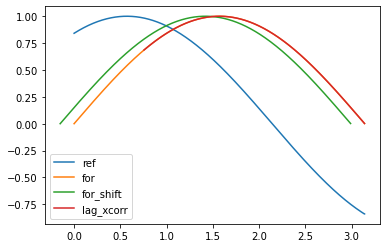

In [98]:
## testing this approach, WITHOUT interpolation of the signal (all timeseries are same length)
num_els = 600
for_time = np.arange(0,180,.1) * np.pi / 180. 
for_vals = np.sin(for_time)
ref_time = for_time[::2]
ref_vals = np.sin(ref_time+1)
ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly

# compute temporal lag
def err_func(p):
    # print(p)
    return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate",assume_sorted=True)(for_time[1:-1]+p[0]) - for_vals[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]
lag_xcorr = lag_calc(ref_vals_interp,for_vals)
print(found_shift)
print(lag_xcorr)
plt.plot(for_time,ref_vals_interp,label='ref')
plt.plot(for_time,for_vals,label='for')
plt.plot(for_time+found_shift,for_vals,label='for_shift')
plt.plot(for_time[lag_xcorr*-1:],for_vals[lag_xcorr*-1:],label='lag_xcorr')

plt.legend()

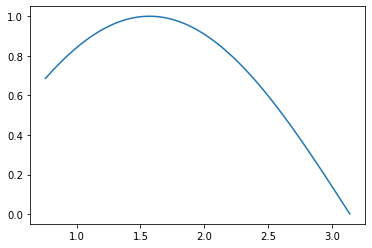

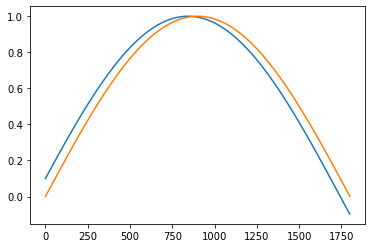

In [47]:
# compute temporal lag
def err_func(p):
    # print(p)
    return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate",assume_sorted=True)(for_time[1:-1]+p[0]) - for_vals[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]
print(found_shift)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [42]:
# plt.plot(interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate",assume_sorted=True)(for_time[1:-1]))
# plt.plot(for_time,for_vals)
ref_vals.shape

(121,)

In [56]:
plt.plot(interp1d(f_time,t_vals_interp,kind='cubic')(f_time[1:-1]+40) - f_vals[1:-1])

ValueError: A value in x_new is above the interpolation range.

221.48362918082947


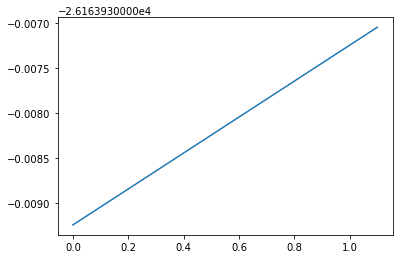

In [69]:
x_new = np.linspace(0,1.1,1000)
intfunc = interp1d(f_time,t_vals_interp,fill_value="extrapolate")

# plt.plot(f_time,t_vals_interp)
plt.plot(x_new,intfunc(x_new))

In [74]:
f_time.max()

13106296.01

In [78]:
crosscorr = np.correlate(f_vals,t_vals_interp,mode='full')
max_idx = np.where(crosscorr==np.max(crosscorr))[0]
if max_idx.shape[0] > 1:
    print("Oh no, you have more than one location with max lag!")
    return 9999


array([149])

array(0)

(array([403]),)

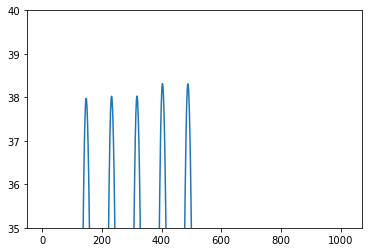

In [34]:
plt.plot(crosscorr),plt.ylim([35,40])
np.where(crosscorr==np.max(crosscorr))